In [1]:
library(sits)
set.seed(123)

SITS - satellite image time series analysis.

Loaded sits v1.5.1.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.



### Create cube

In [2]:
Sys.setenv("PROJ_LIB"="/usr/share/proj")

In [32]:
#
# General definitions
#

# Dates
y <- "2022"

# Cube directory
cube_dir <- "../data/output/PE/cube/"

# Bands
cube_bands <- c(
  "B02", "B03", "B04", "B08", "B11", "B12", "B8A", "EVI", "NDVI", "CLOUD"
)

# Hardware - multicores
multicores <- 24

#
# 1. Create cube directory
#
dir.create(cube_dir, recursive = TRUE)

#
# 2. Read ROI
#
tile <- c("035015", "036015", "036016")

#
# 3. Generate cubes
#
# define dates
start_date <- paste0("2021-10-16")
end_date <- paste0("2022-09-30")

# load cube
cube <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    tiles      = tile,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

Warning message in dir.create(cube_dir, recursive = TRUE):
“'../data/output/PE/cube' already exists”


  |======================================================================| 100%


In [4]:
print(cube)

# A tibble: 3 × 12
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    SENTINEL-2-16D SENTINEL… MSI    0350… 6.32e6 6.43e6 1.03e7 1.04e7 "PRO…
2 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.03e7 1.04e7 "PRO…
3 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.02e7 1.03e7 "PRO…
# ℹ 2 more variables: labels <list>, file_info <list>


### Reading Samples

In [5]:
#
# General definition
#

# Samples
samples_file <- "../data/output/PE/time_series/clean_samples_2019_2020_band.rds"

# Output directory
base_output_dir <- "../data/output/PE"

#
# 1. Load samples
#
samples <- readRDS(samples_file)

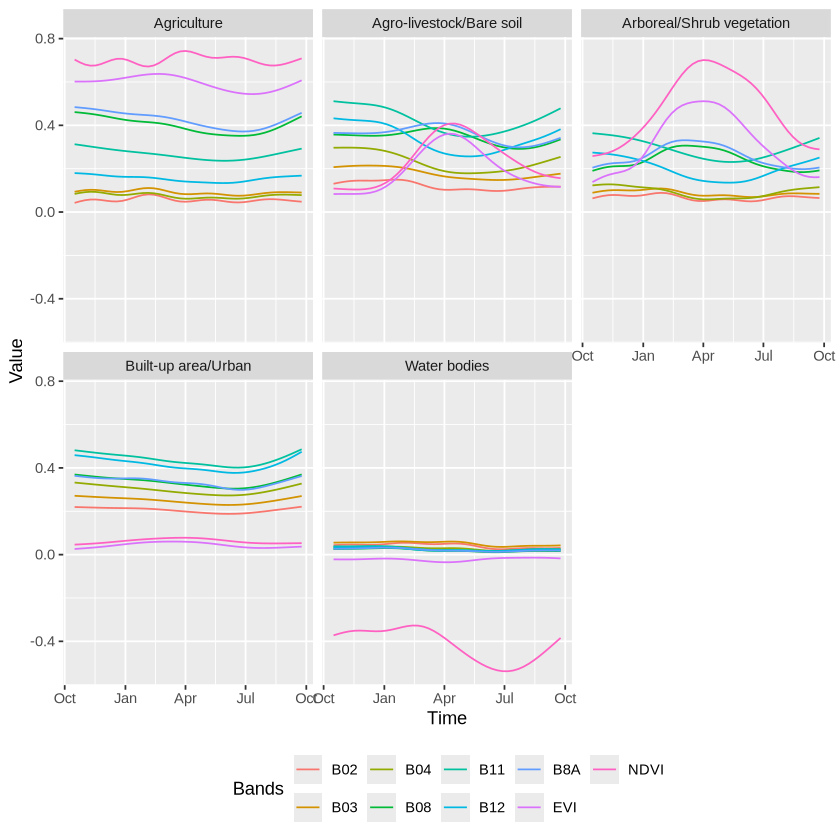

In [6]:
plot(sits_patterns(samples))

### Tunning CNN

In [7]:
#
# 2. Train model
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%


In [8]:
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.989 0.986 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 2    0.989 0.986 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.989 0.986 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 4    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 6    0.984 0.979 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 7    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 8    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 9    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(5, 5, 5) 
10    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

In [10]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_pe.rds"))

Warning message in dir.create(tuning_dir, recursive = TRUE):
“'../data/output/PE/tune/tempcnn' already exists”


In [11]:
tuned_tempcnn <- readRDS("../data/output/PE/tune/tempcnn/tempcnn_pe.rds")

### Training CNN

In [13]:
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^6, 2^6, 2^6),
          cnn_kernels = c(7, 7, 7),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.0003105814),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [14]:
environment(tcnn_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 8.6s
• Avg time per training epoch: 219ms

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.0584
acc: 0.9872

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 440,837 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• conv_bn_relu1: <conv1D_batch_norm

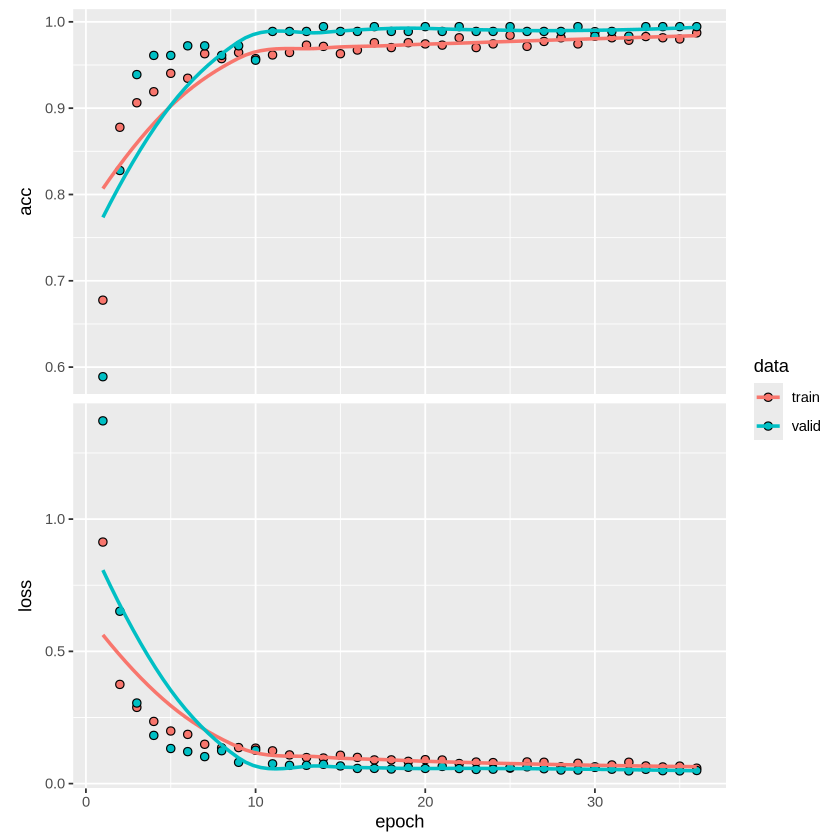

In [15]:
plot(tcnn_model)

In [16]:
#
# 3. Save model
#

base_model_dir <- "../data/output/PE/model/"

tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

# create directory
dir.create(base_model_dir, recursive = TRUE)

# save
saveRDS(tcnn_model, tcnn_dir)

In [17]:
tcnn_model <- readRDS("../data/output/PE/model/tcnn_model.rds")

### Tuning LightTAE

In [21]:
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 10,
  progress   = TRUE
)

  |======================================================================| 100%


In [22]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/lighttae/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_pe.rds"))

In [23]:
tuned_lighttae <- readRDS("../data/output/PE/tune/lighttae/lighttae_pe.rds")

In [24]:
print(tuned_lighttae[1,]$opt_hparams)

[[1]]
# A tibble: 1 × 2
        lr weight_decay
     <dbl>        <dbl>
1 0.000273      0.00161



### Training LightTAE

In [25]:
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.000273, weight_decay = 0.00161),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [32]:
environment(lighttae_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 1m 29.8s
• Avg time per training epoch: 1.5s

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.1252
acc: 0.9643

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 127,867 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• spatial_encoder: <torch_pixel_

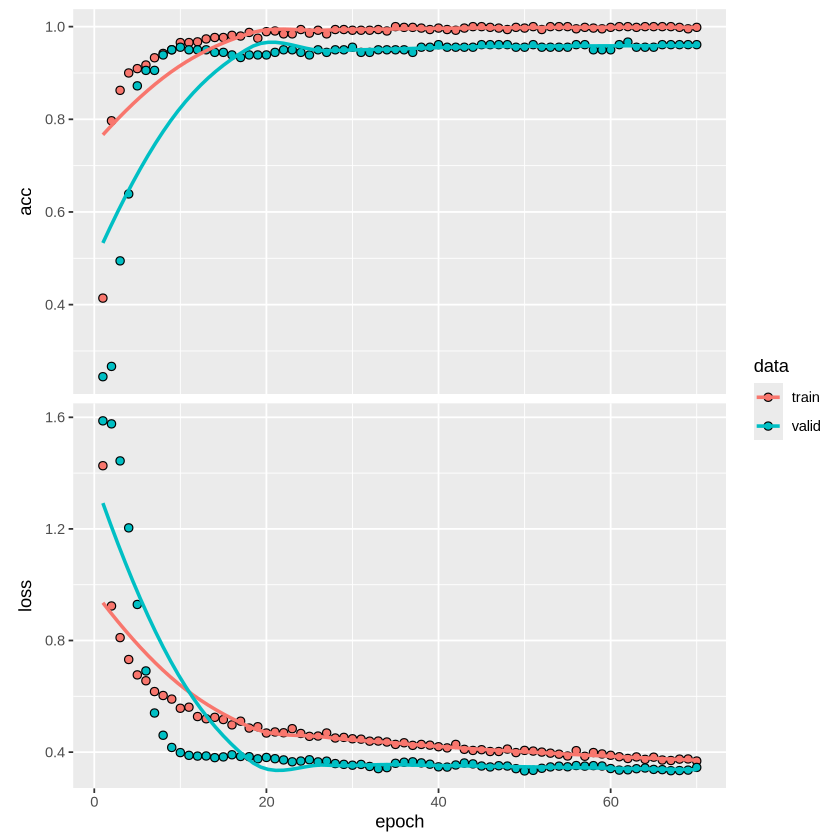

In [26]:
plot(lighttae_model)

In [27]:
#
# 3. Save model
#

ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

# save
saveRDS(lighttae_model, ltae_dir)

In [28]:
lighttae_model <- readRDS("../data/output/PE/model/ltae_model.rds")

### Pixel-based classification - TCNN

In [40]:
# Output directory
output_dir <- "../data/output/PE/classifications/tccn"

# Version
results_version <- "tcnn-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#

# classify
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/classifications/tccn' already exists”
using blocks of size 512 x 5632

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-04 12:24:07.299861

elapsed time for task0.05 secs



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Pixel-based classification - LightTAE

In [44]:
# Output directory
output_dir <- "../data/output/PE/classifications/lighttae"

# Version
results_version <- "lighttaeb-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/classifications/lighttae' already exists”
using blocks of size 512 x 5632

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-04 19:53:25.38606

elapsed time for task0.06 secs



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Apply Spatial-temporal segmentation

In [45]:
segment_dir <- "../data/output/PE/segment/"
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Object-based classification - TCNN

In [ ]:
# Output directory
output_dir <- "../data/output/PE/segment/tcnn"

# Version
results_version <- "tcnn-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/segment/tcnn' already exists”


  |                                                                      |   0%

Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71283946 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==                                                                    |   2%

Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71208460 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |===                                                                   |   5%

Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71506701 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |=====                                                                 |   7%

Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 71662250 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |                                                                      |   0%

### Object-based classification - LightTae

In [ ]:
# Output directory
output_dir <- "../data/output/PE/segment/ltae"

# Version
results_version <- "ltae-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/RO/segment/ltae' already exists”
Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
